In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os

# Load model weights.
USE_FULL_1900_DIM_MODEL = False # if True use 1900 dimensional model, else use 64 dimensional one.

# Set seeds
tf.set_random_seed(42)
np.random.seed(42)

if USE_FULL_1900_DIM_MODEL:
    # Sync relevant weight files
    !aws s3 sync --no-sign-request --quiet s3://unirep-public/1900_weights/ 1900_weights/
    
    # Import the mLSTM babbler model
    from unirep import babbler1900 as babbler
    
    # Where model weights are stored.
    MODEL_WEIGHT_PATH = "./1900_weights"
    
else:
    # Sync relevant weight files
    !aws s3 sync --no-sign-request --quiet s3://unirep-public/64_weights/ 64_weights/
    
    # Import the mLSTM babbler model
    from unirep import babbler64 as babbler
    
    # Where model weights are stored.
    MODEL_WEIGHT_PATH = "./64_weights"
    
    
def nonpad_len(batch):
    nonzero = batch > 0
    lengths = np.sum(nonzero, axis=1)
    return lengths    
    
    
# Create babbler.
batch_size = 64
b = babbler(batch_size=batch_size, model_path=MODEL_WEIGHT_PATH)


hidden_vals_filename = 'sarkisyan_final_hidden_vals.txt'
seqs_filename = 'sarkisyan_filtered_seqs.txt'
brightness_filename = 'sarkisyan_filtered_brightness.txt'


if os.path.exists(seqs_filename) and os.path.exists(brightness_filename):
    seqs = np.loadtxt(seqs_filename)
    brightness = np.loadtxt(brightness_filename)
else:
    # Load sarkisyan dataset
    sarkisyan = pd.read_csv('sarkisyan.csv')
    sequences = []
    brightness = []
    stop_codon_cnt = 0
    for i, row in sarkisyan.iterrows():
        seq = row.seq.strip('*')
        if b.is_valid_seq(seq) and len(seq) < 275: 
            sequences.append(b.format_seq(seq))
            brightness.append(row.medianBrightness)
        else:
            if '*' in seq:
                stop_codon_cnt += 1
            else:
                print('Invalid seq', seq)
    seqs = np.stack(sequences)
    brightness = np.array(brightness)[:, None]
    print('Formatted %d sequences. Discarded %d with stop codon.' % (seqs.shape[0], stop_codon_cnt))
    np.savetxt(seqs_filename, seqs)
    np.savetxt(brightness_filename, brightness)

    
if os.path.exists(hidden_vals_filename):
    final_hidden_vals = np.loadtxt(hidden_vals_filename)
else:
    final_hidden_op, x_placeholder, batch_size_placeholder, seq_length_placeholder, initial_state_placeholder = (
        b.get_rep_ops())
    final_hidden_vals = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        n_batches = int(seqs.shape[0] / batch_size)
        leftover = seqs.shape[0] % batch_size
        n_batches += int(bool(leftover))
        for i in range(n_batches):
            if i == n_batches - 1:
                batch = seqs[-batch_size:]
            else:
                batch = seqs[i*batch_size:(i+1)*batch_size]
            length = nonpad_len(batch)
            final_hidden_ = sess.run(
                final_hidden_op,
                feed_dict={
                    x_placeholder: batch,
                    batch_size_placeholder: batch.shape[0],
                    seq_length_placeholder: length,
                    initial_state_placeholder:b._zero_state
                })
            if i == n_batches - 1:
                final_hidden_vals.append(final_hidden_[-leftover:])
            else:
                final_hidden_vals.append(final_hidden_)

    final_hidden_vals = np.concatenate(final_hidden_vals, axis=0)
    np.savetxt(hidden_vals_filename, final_hidden_vals)

/bin/sh: aws: command not found



Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API

Instructions for updating:
dim is deprecated, use axis instead
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/pro

In [2]:
final_hidden_vals

(51715, 64)

In [10]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=6)
pca.fit(final_hidden_vals)
pcs = pca.transform(final_hidden_vals)

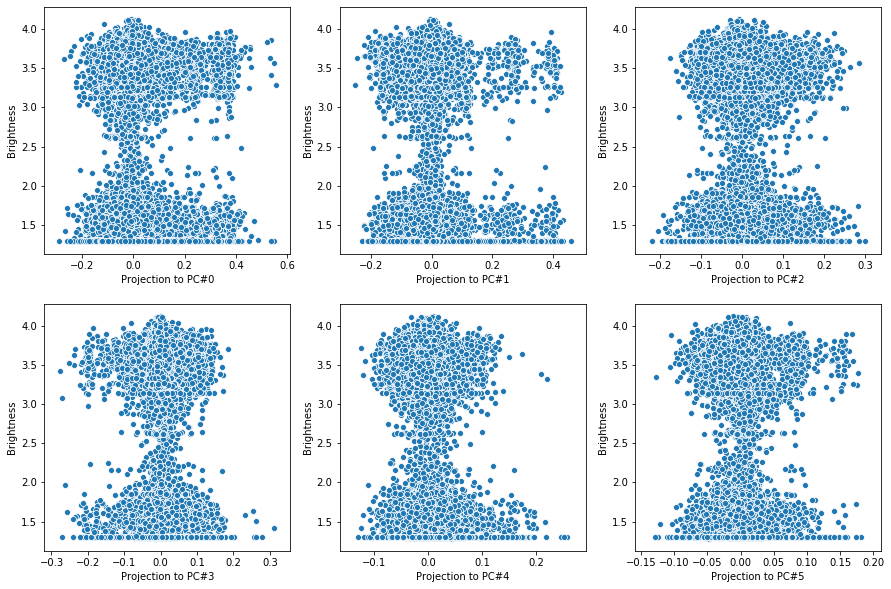

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i in range(pcs.shape[1]):
    ax = axes.flatten()[i]
    sns.scatterplot(pcs[:, i], brightness, ax=ax)
    ax.set_xlabel('Projection to PC#%d' % i)
    ax.set_ylabel('Brightness')
plt.show()

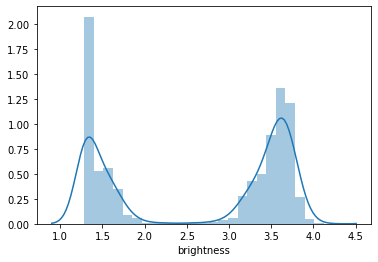

In [18]:
sns.distplot(brightness)
plt.xlabel('brightness')
plt.show()